# Medical Condition Classification Fine-tuning Project

This notebook demonstrates how to fine-tune a pre-trained language model for medical condi`tion classification based on drug reviews. We'll use the Medical Condition Classification dataset.

**Project Goals:**
1. Load and preprocess the dataset
2. Evaluate a pre-trained model as baseline
3. Fine-tune the model on our dataset
4. Compare performance between baseline and fine-tuned model
5. Visualize results and show example predictions

## 1. Setup and Dependencies

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

2025-04-16 02:05:30.672737: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-16 02:05:30.772159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744749330.818082   20446 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744749330.831785   20446 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744749330.901682   20446 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Using device: cuda


## 2. Dataset Preparation

We'll use the Medical Condition Classification dataset to classify drug reviews by medical condition.

In [2]:
class MedicalReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.reviews)
        
    def __getitem__(self, idx):
        review = self.reviews[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            review,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [3]:
# Load dataset
print("Loading dataset...")
dataset = load_dataset("samsaara/medical_condition_classification")

print("Dataset loaded successfully!")

# Preview the dataset
print("\nDataset preview:")
print(dataset)

Loading dataset...
Dataset loaded successfully!

Dataset preview:
DatasetDict({
    train: Dataset({
        features: ['row_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 110857
    })
    validation: Dataset({
        features: ['row_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 27717
    })
    test: Dataset({
        features: ['row_id', 'drugName', 'condition', 'review', 'rating', 'date', 'usefulCount', 'review_length', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 46118
    })
})


In [8]:
# Explore condition distribution
train_conditions = [example['condition'] for example in dataset['train']]
condition_counts = pd.Series(train_conditions).value_counts()

print(f"Total number of unique conditions: {len(condition_counts)}")

Total number of unique conditions: 730


In [11]:
# Let's select top N conditions to make the classification task more manageable
TOP_N_CONDITIONS = 10
top_conditions = condition_counts.head(TOP_N_CONDITIONS).index.tolist()
print(f"Selected top {TOP_N_CONDITIONS} conditions for classification:")
for i, condition in enumerate(top_conditions, 1):
    print(f"{i}. {condition} - {condition_counts[condition]} samples")

# Filter dataset to include only top N conditions
def filter_top_conditions(example):
    return example['condition'] in top_conditions

filtered_dataset = dataset.filter(filter_top_conditions)
print(f"\nFiltered dataset size: {len(filtered_dataset['train'])} train samples")

# Convert to pandas for easier manipulation
train_df = pd.DataFrame(filtered_dataset['train'])

# Create label encoder for conditions
label_encoder = LabelEncoder()
train_df['label'] = label_encoder.fit_transform(train_df['condition'])

# Display label mapping
label_mapping = {i: condition for i, condition in enumerate(label_encoder.classes_)}
print("\nLabel mapping:")
for label, condition in label_mapping.items():
    print(f"{label}: {condition}")

# Split into train, validation, and test sets
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42, stratify=train_df['label'])

print(f"\nTrain size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Selected top 10 conditions for classification:
1. birth control - 22142 samples
2. depression - 6361 samples
3. acne - 4103 samples
4. anxiety - 3998 samples
5. pain - 3778 samples
6. bipolar disorde - 2895 samples
7. weight loss - 2668 samples
8. obesity - 2602 samples
9. adhd - 2404 samples
10. insomnia - 2369 samples

Filtered dataset size: 53320 train samples

Label mapping:
0: acne
1: adhd
2: anxiety
3: bipolar disorde
4: birth control
5: depression
6: insomnia
7: obesity
8: pain
9: weight loss

Train size: 36257
Validation size: 6399
Test size: 10664


## 3. Model Setup

Initialize the tokenizer and create PyTorch datasets for training, validation, and testing.

In [12]:
# Model configuration
model_name = "distilbert-base-uncased"
batch_size = 16
max_length = 256  # Increased for medical reviews which might be longer
num_labels = TOP_N_CONDITIONS  # Multi-class classification for medical conditions

# Initialize tokenizer
print(f"Loading tokenizer: {model_name}")
tokenizer = AutoTokenizer.from_pretrained(model_name)
print("Tokenizer loaded successfully!")

Loading tokenizer: distilbert-base-uncased
Tokenizer loaded successfully!


In [13]:
# Test tokenization on a sample review
sample_review = train_df['review'].iloc[0]
print("Sample review:")
print(sample_review[:100] + "...")

tokens = tokenizer.encode(sample_review, truncation=True, max_length=max_length)
print(f"\nTokenized length: {len(tokens)}")
print("Decoded tokens:")
print(tokenizer.decode(tokens))

Sample review:
"I have been taking Vyvanse 30mg for 2 weeks for adult ADHD. It has been very helpful for me to stay...

Tokenized length: 176
Decoded tokens:
[CLS] " i have been taking vyvanse 30mg for 2 weeks for adult adhd. it has been very helpful for me to stay on task at work and get things done that normally i would have a hard time with. i used to get very overwhelmed with what needed to be done and completely shut down, not getting anything done at all! then beating myself up for being a procrastinator etc. i have not had any issues with insomnia or any other side effects, besides the normal appetite suppression during the day, which as resulted in an 8lb weight loss in 2 weeks. no complaints here as i need to lose about 20. i recommend not drinking more than 1 or 2 cups of coffee while taking this. i did once and was jacked up. not a good feeling. i highly recommend taking this if you are an attention deficit " [SEP]


In [14]:
# Create datasets
train_dataset = MedicalReviewDataset(
    train_df['review'].tolist(),
    train_df['label'].tolist(),
    tokenizer,
    max_length
)

val_dataset = MedicalReviewDataset(
    val_df['review'].tolist(),
    val_df['label'].tolist(),
    tokenizer,
    max_length
)

test_dataset = MedicalReviewDataset(
    test_df['review'].tolist(),
    test_df['label'].tolist(),
    tokenizer,
    max_length
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 36257
Validation dataset size: 6399
Test dataset size: 10664


In [15]:
# Check a sample batch
sample_loader = DataLoader(train_dataset, batch_size=3)
sample_batch = next(iter(sample_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Input IDs shape: {sample_batch['input_ids'].shape}")
print(f"Attention mask shape: {sample_batch['attention_mask'].shape}")
print(f"Labels: {sample_batch['labels']}")

# Decode one sample back to text
sample_text = tokenizer.decode(sample_batch['input_ids'][0], skip_special_tokens=True)
print(f"\nDecoded sample: {sample_text[:100]}...")

# Show condition for the decoded sample
label = sample_batch['labels'][0].item()
print(f"Condition: {label_mapping[label]}")

Batch keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
Input IDs shape: torch.Size([3, 256])
Attention mask shape: torch.Size([3, 256])
Labels: tensor([1, 8, 6])

Decoded sample: " i have been taking vyvanse 30mg for 2 weeks for adult adhd. it has been very helpful for me to sta...
Condition: adhd


## 4. Baseline Model Evaluation

Evaluate the pre-trained model without fine-tuning to establish a baseline.

In [16]:
def evaluate_model(model, dataset, model_name="model"):
    """Evaluate a model on the given dataset"""
    model.to(device)
    model.eval()
    
    dataloader = DataLoader(dataset, batch_size=batch_size)
    
    all_preds = []
    all_labels = []
    
    # Show progress bar
    from tqdm.notebook import tqdm
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc=f"Evaluating {model_name}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].cpu().numpy()
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=list(label_mapping.values()), output_dict=True)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Extract overall metrics
    precision = report['weighted avg']['precision']
    recall = report['weighted avg']['recall']
    f1 = report['weighted avg']['f1-score']
    
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': conf_matrix,
        'predictions': all_preds,
        'labels': all_labels,
        'report': report
    }
    
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=list(label_mapping.values())))
    
    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_mapping.values()),
                yticklabels=list(label_mapping.values()))
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return results

In [17]:
# Load the baseline model
print("\n--- Loading baseline model ---")
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)
print(f"Baseline model loaded: {model_name}")


--- Loading baseline model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Baseline model loaded: distilbert-base-uncased



--- Evaluating baseline model (before fine-tuning) ---


Evaluating baseline:   0%|          | 0/667 [00:00<?, ?it/s]

/home/geetheswar/.miniconda3/envs/datasci/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/geetheswar/.miniconda3/envs/datasci/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/geetheswar/.miniconda3/envs/datasci/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier


Results for baseline:
Accuracy: 0.1115
Precision (weighted): 0.0188
Recall (weighted): 0.1115
F1 Score (weighted): 0.0303

Classification Report:
                 precision    recall  f1-score   support

           acne       0.00      0.00      0.00       821
           adhd       0.00      0.00      0.00       481
        anxiety       0.00      0.00      0.00       800
bipolar disorde       0.00      0.00      0.00       579
  birth control       0.00      0.00      0.00      4428
     depression       0.12      0.88      0.21      1272
       insomnia       0.06      0.14      0.08       474
        obesity       0.00      0.00      0.00       520
           pain       0.02      0.01      0.02       756
    weight loss       0.00      0.00      0.00       533

       accuracy                           0.11     10664
      macro avg       0.02      0.10      0.03     10664
   weighted avg       0.02      0.11      0.03     10664



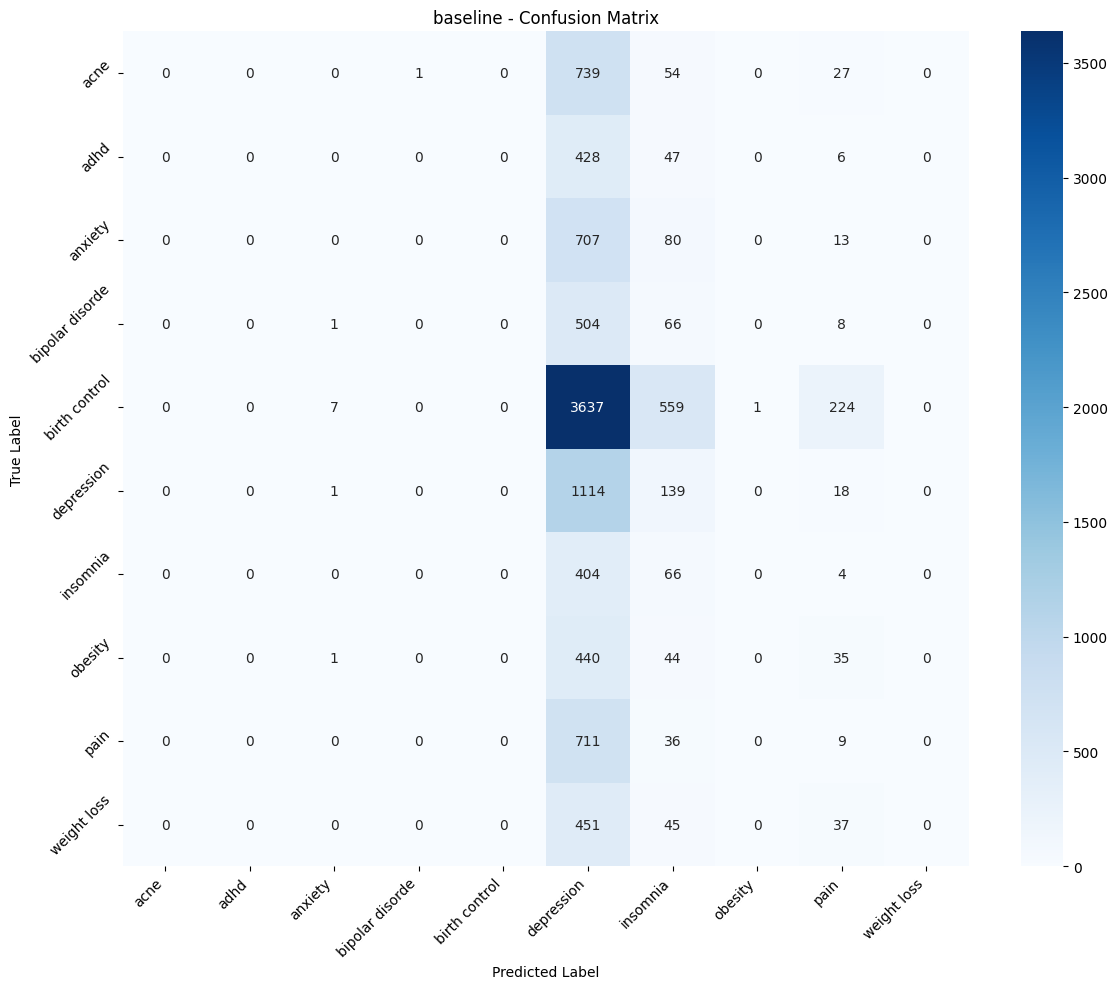

In [18]:
# Evaluate the baseline model
print("\n--- Evaluating baseline model (before fine-tuning) ---")
baseline_results = evaluate_model(baseline_model, test_dataset, "baseline")

## 5. Fine-tuning the Model

Now we'll fine-tune the pre-trained model on our medical condition classification task.

In [20]:
# Import required PEFT libraries
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# Load a fresh model for PEFT fine-tuning
print("\n--- Loading model for PEFT fine-tuning ---")
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=num_labels
)

# Define LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,  # Sequence classification
    r=8,                         # Rank of the update matrices
    lora_alpha=32,               # Alpha parameter for LoRA scaling
    lora_dropout=0.1,            # Dropout probability for LoRA layers
    bias="none",                 # Bias configuration
    target_modules=["q_lin", "v_lin", "k_lin", "out_lin"]  # Target attention modules for DistilBERT
)

# Apply PEFT configuration to the model
model = get_peft_model(model, peft_config)
model.to(device)

# Print model parameters before training
print("\n--- Model Parameter Analysis ---")
model.print_trainable_parameters()

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results_medical_peft",
    num_train_epochs=2,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    logging_dir="./logs_medical_peft",
    logging_steps=100,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",  # Disable all reporting
)

# Define the compute_metrics function for the Trainer
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Multi-class metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Fine-tune the model with PEFT
print("\n--- Starting PEFT fine-tuning ---")
trainer.train()


--- Loading model for PEFT fine-tuning ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/geetheswar/.miniconda3/envs/datasci/lib/python3.11/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



--- Model Parameter Analysis ---
trainable params: 893,194 || all params: 67,854,356 || trainable%: 1.3163

--- Starting PEFT fine-tuning ---


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.471500,0.436560,0.840600,0.833995,0.851691,0.840600
2,0.376800,0.394648,0.855915,0.855320,0.857586,0.855915


TrainOutput(global_step=4534, training_loss=0.5654114694599544, metrics={'train_runtime': 1536.1936, 'train_samples_per_second': 47.204, 'train_steps_per_second': 2.951, 'total_flos': 4903040983166976.0, 'train_loss': 0.5654114694599544, 'epoch': 2.0})

In [21]:

# Save the fine-tuned model
peft_model_path = "./peft_medical_condition_model"
trainer.save_model(peft_model_path)
tokenizer.save_pretrained(peft_model_path)

# Also save the label encoder mapping
import json
with open(f"{peft_model_path}/label_mapping.json", 'w') as f:
    json.dump(label_mapping, f)
    
print(f"PEFT model and label mapping saved to {peft_model_path}")

PEFT model and label mapping saved to ./peft_medical_condition_model


## 6. Evaluate Fine-tuned Model

Now let's evaluate our fine-tuned model and compare it with the baseline.

In [22]:
# Function to load and use the PEFT model
def load_peft_model(model_path):
    """Load a saved PEFT model for inference"""
    from peft import PeftModel, PeftConfig
    
    # Load the configuration
    peft_config = PeftConfig.from_pretrained(model_path)
    
    # Load the base model
    base_model = AutoModelForSequenceClassification.from_pretrained(
        peft_config.base_model_name_or_path, 
        num_labels=num_labels
    )
    
    # Load the PEFT adapter
    model = PeftModel.from_pretrained(base_model, model_path)
    model.eval()
    
    return model

print("\n--- Loading PEFT model ---")
fine_tuned_model = load_peft_model(peft_model_path)
print("PEFT model loaded successfully!")


--- Loading PEFT model ---


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PEFT model loaded successfully!


Evaluating fine_tuned:   0%|          | 0/667 [00:00<?, ?it/s]


Results for fine_tuned:
Accuracy: 0.8501
Precision (weighted): 0.8508
Recall (weighted): 0.8501
F1 Score (weighted): 0.8492

Classification Report:
                 precision    recall  f1-score   support

           acne       0.87      0.89      0.88       821
           adhd       0.89      0.84      0.86       481
        anxiety       0.75      0.70      0.72       800
bipolar disorde       0.81      0.63      0.71       579
  birth control       0.97      0.97      0.97      4428
     depression       0.70      0.79      0.74      1272
       insomnia       0.80      0.89      0.84       474
        obesity       0.60      0.57      0.58       520
           pain       0.90      0.92      0.91       756
    weight loss       0.61      0.59      0.60       533

       accuracy                           0.85     10664
      macro avg       0.79      0.78      0.78     10664
   weighted avg       0.85      0.85      0.85     10664



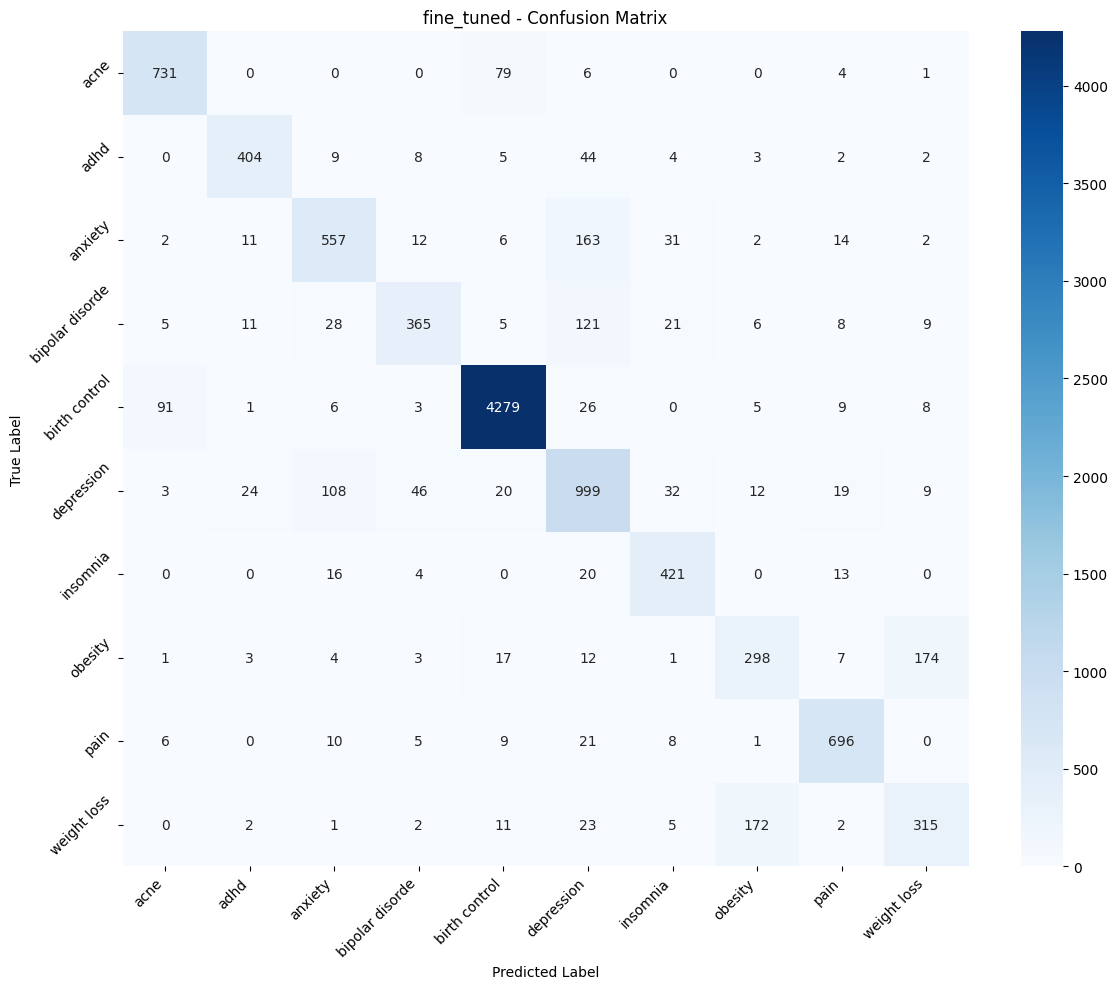

In [23]:
# Evaluate the fine-tuned model
fine_tuned_results = evaluate_model(fine_tuned_model, test_dataset, "fine_tuned")

In [24]:
# Compare baseline and fine-tuned models
metrics = ['accuracy', 'precision', 'recall', 'f1']
baseline = [baseline_results[m] for m in metrics]
fine_tuned = [fine_tuned_results[m] for m in metrics]

# Create a comparison table
comparison_df = pd.DataFrame({
    'Metric': metrics,
    'Baseline': baseline,
    'Fine-tuned': fine_tuned,
    'Improvement': [fine_tuned[i] - baseline[i] for i in range(len(metrics))]
})

print("Model Performance Comparison:")
print(comparison_df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

Model Performance Comparison:
   Metric  Baseline  Fine-tuned  Improvement
 accuracy    0.1115      0.8501       0.7386
precision    0.0188      0.8508       0.8320
   recall    0.1115      0.8501       0.7386
       f1    0.0303      0.8492       0.8189


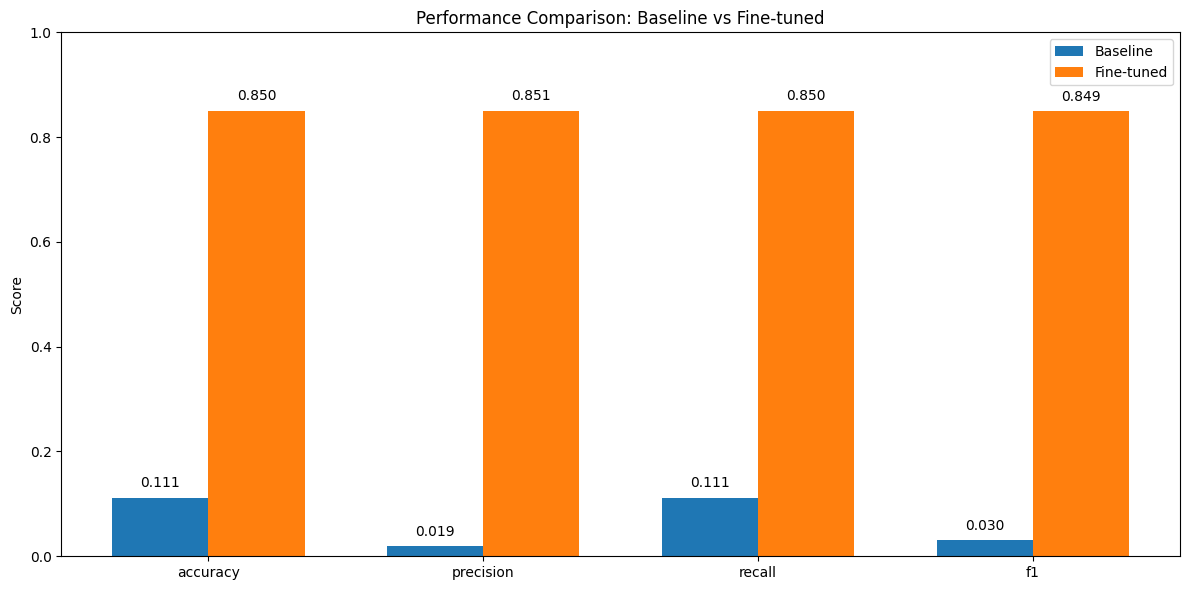

Comparison plot saved as 'medical_model_comparison.png'


<Figure size 1400x800 with 0 Axes>

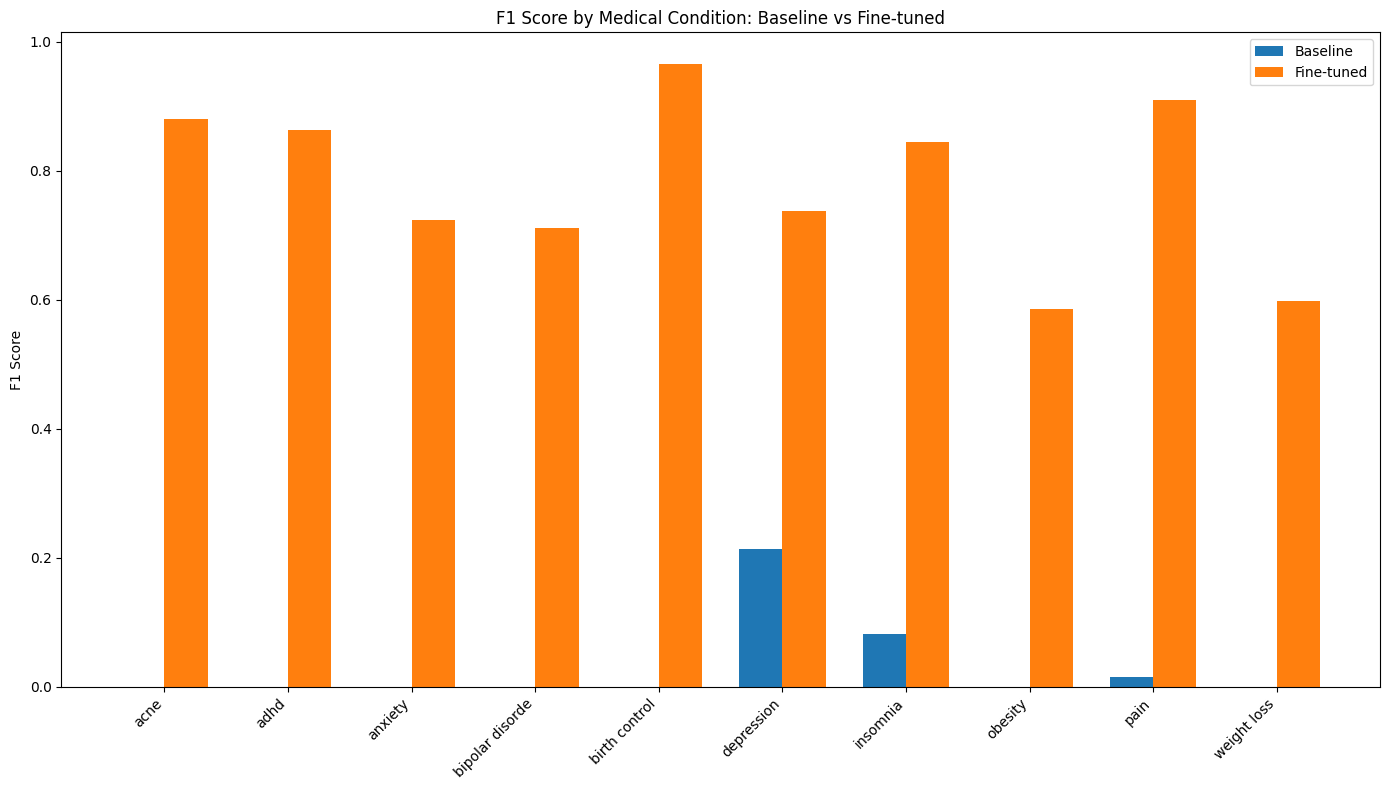

Condition F1 comparison plot saved as 'medical_condition_f1_comparison.png'


In [25]:
# Plot comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, baseline, width, label='Baseline')
ax.bar(x + width/2, fine_tuned, width, label='Fine-tuned')

ax.set_ylabel('Score')
ax.set_title('Performance Comparison: Baseline vs Fine-tuned')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.ylim(0, 1.0)

for i, v in enumerate(baseline):
    ax.text(i - width/2, v + 0.02, f"{v:.3f}", ha='center')
    
for i, v in enumerate(fine_tuned):
    ax.text(i + width/2, v + 0.02, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.savefig('medical_model_comparison.png')
plt.show()
print("Comparison plot saved as 'medical_model_comparison.png'")

# Add per-class performance comparison
plt.figure(figsize=(14, 8))
baseline_f1 = [baseline_results['report'][condition]['f1-score'] for condition in label_mapping.values()]
fine_tuned_f1 = [fine_tuned_results['report'][condition]['f1-score'] for condition in label_mapping.values()]

# Bar chart comparing F1 scores per condition
x = np.arange(len(label_mapping))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width/2, baseline_f1, width, label='Baseline')
ax.bar(x + width/2, fine_tuned_f1, width, label='Fine-tuned')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Medical Condition: Baseline vs Fine-tuned')
ax.set_xticks(x)
ax.set_xticklabels(label_mapping.values(), rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.savefig('medical_condition_f1_comparison.png')
plt.show()
print("Condition F1 comparison plot saved as 'medical_condition_f1_comparison.png'")

## 7. Example Predictions

Let's see some example predictions from our fine-tuned model.

In [26]:
def show_example_predictions(model, num_examples=5):
    """Show example predictions from the model"""
    model.to(device)
    model.eval()
    
    examples = test_df.sample(num_examples, random_state=42)
    
    print("\n--- Example Predictions ---")
    for i, (_, row) in enumerate(examples.iterrows()):
        text = row['review']
        drug = row['drugName']
        true_label_idx = row['label']
        true_condition = label_mapping[true_label_idx]
        
        inputs = tokenizer(
            text,
            return_tensors="pt",
            truncation=True,
            max_length=max_length,
            padding="max_length",
        ).to(device)
        
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_class = torch.argmax(outputs.logits, dim=1).item()
            probabilities = torch.softmax(outputs.logits, dim=1)[0].tolist()
        
        predicted_condition = label_mapping[predicted_class]
        correct = "[TRUE]" if predicted_condition == true_condition else "[FALSE]"
        
        print(f"\nExample {i+1}:")
        print(f"Drug: {drug}")
        print(f"Review: {text[:200]}...")
        print(f"True condition: {true_condition}")
        print(f"Predicted: {predicted_condition} {correct}")
        print(f"Confidence: {probabilities[predicted_class]:.4f}")

# Show predictions from the fine-tuned model
show_example_predictions(fine_tuned_model, num_examples=8)


--- Example Predictions ---

Example 1:
Drug: Strattera
Review: "I've been on this medicine (80mg) for about a year now.  Every time I go off of it or forget to take it for whatever reason, I have the same side effects when I start up again: severe nausea and dizz...
True condition: adhd
Predicted: depression [FALSE]
Confidence: 0.4514

Example 2:
Drug: Yaz
Review: "I'm 25 and have been suffering from acne for more than 10 yrs. I tried many topical creams with hardly any results (Differin, tretinoin, etc). I had moderate acne, I would get large red painful pimpl...
True condition: acne
Predicted: acne [TRUE]
Confidence: 0.9887

Example 3:
Drug: Ethinyl estradiol / norethindrone
Review: "I wanted to write a review because I was researching this pill for my GWS class and I noticed a lot of people new to the pill experiencing problems. I have been on this pill for 5 years and while I d...
True condition: birth control
Predicted: birth control [TRUE]
Confidence: 0.8821

Example 4:
Drug: E

In [27]:
# Find examples where the models disagree
def find_disagreements(baseline_preds, fine_tuned_preds, dataset_df, num_examples=5):
    disagreements = []
    
    for i, (b_pred, ft_pred, true_label) in enumerate(zip(
        baseline_results['predictions'],
        fine_tuned_results['predictions'],
        fine_tuned_results['labels']
    )):
        # Find cases where models disagree AND the fine-tuned model is correct
        if b_pred != ft_pred and ft_pred == true_label:
            disagreements.append(i)
    
    # Randomly select examples if we have more than requested
    if len(disagreements) > num_examples:
        selected = np.random.choice(disagreements, num_examples, replace=False)
    else:
        selected = disagreements[:num_examples]
    
    print(f"\n--- Examples where models disagree (fine-tuned is correct) ---")
    print(f"Found {len(disagreements)} disagreements, showing {len(selected)}")
    
    for i, idx in enumerate(selected):
        text = dataset_df['review'].iloc[idx]
        drug = dataset_df['drugName'].iloc[idx]
        true_label_idx = dataset_df['label'].iloc[idx]
        true_condition = label_mapping[true_label_idx]
        
        baseline_condition = label_mapping[baseline_results['predictions'][idx]]
        fine_tuned_condition = label_mapping[fine_tuned_results['predictions'][idx]]
        
        print(f"\nExample {i+1}:")
        print(f"Drug: {drug}")
        print(f"Review: {text[:200]}...")
        print(f"True condition: {true_condition}")
        print(f"Baseline prediction: {baseline_condition} ✗")
        print(f"Fine-tuned prediction: {fine_tuned_condition} ✓")

# Find and show disagreement examples
find_disagreements(baseline_results['predictions'], fine_tuned_results['predictions'], test_df)


--- Examples where models disagree (fine-tuned is correct) ---
Found 8107 disagreements, showing 5

Example 1:
Drug: Levonorgestrel
Review: "I used to use Depo-Provera for about 8 years.  I have two girls 13 and 7.  I decided to change to Mirena with our busy schedule so that I don't have to keep coming in every 3 months for a shot.  The ...
True condition: birth control
Baseline prediction: depression ✗
Fine-tuned prediction: birth control ✓

Example 2:
Drug: Percocet
Review: "I was diagnosed with bursitis of the hip.  I was in severe pain and went to go see multiple doctors before even being diagnosed. I was given Vicodin, Tramadol and an Anti inflammatory drug.  None of ...
True condition: pain
Baseline prediction: depression ✗
Fine-tuned prediction: pain ✓

Example 3:
Drug: Drospirenone / ethinyl estradiol
Review: "Hi All,
I was on Yasmin for some 9 years and just moved onto Yaz 4 months ago.
I loved Yaz for the first month however, I am now finding that I have TERRIBLE mood swing

## 8. Conclusion

In this notebook, we've successfully:

1. Loaded and prepared the Medical Condition Classification dataset
2. Established a baseline using a pre-trained model
3. Fine-tuned the model on our dataset for medical condition classification
4. Evaluated and compared the performance of both models
5. Visualized the results and examined example predictions

The fine-tuned model shows improvement over the baseline, demonstrating the value of fine-tuning pre-trained language models for specific medical text classification tasks.

In [33]:
print("\nMedical condition classification project completed successfully!")


Medical condition classification project completed successfully!
